# BLOCK P1 - Dataset Structuring & Metadata Canonicalization

## Setup Path + Enumerasi Kelas + Scan File

In [1]:
# =========================================
# [P1.1.1] CONFIG & DATASET PATHS (KAGGLE)
# =========================================

from pathlib import Path

# Root dataset Kaggle (folder paling atas sesuai panel Datasets)
DATASET_ROOT = Path("/kaggle/input/coffee-bean-classification-dataset")

# Subfolder dataset sesuai screenshot
PROJECT_DIR = DATASET_ROOT / "Deteksi Jenis Kopi"
TRAIN_DIR = PROJECT_DIR / "train"
TEST_DIR  = PROJECT_DIR / "test"

# Kontrak label statik (sesuai EDA)
CLASS_NAMES = ["defect", "longberry", "peaberry", "premium"]

# Ekstensi file image yang valid
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

print("DATASET_ROOT:", DATASET_ROOT)
print("PROJECT_DIR:", PROJECT_DIR)
print("TRAIN_DIR:", TRAIN_DIR)
print("TEST_DIR:", TEST_DIR)
print("CLASS_NAMES:", CLASS_NAMES)
print("IMG_EXTS:", sorted(list(IMG_EXTS)))

DATASET_ROOT: /kaggle/input/coffee-bean-classification-dataset
PROJECT_DIR: /kaggle/input/coffee-bean-classification-dataset/Deteksi Jenis Kopi
TRAIN_DIR: /kaggle/input/coffee-bean-classification-dataset/Deteksi Jenis Kopi/train
TEST_DIR: /kaggle/input/coffee-bean-classification-dataset/Deteksi Jenis Kopi/test
CLASS_NAMES: ['defect', 'longberry', 'peaberry', 'premium']
IMG_EXTS: ['.bmp', '.jpeg', '.jpg', '.png', '.webp']


In [2]:
# =========================================
# [P1.1.2] FOLDER STRUCTURE VALIDATION
# =========================================

def _check_split_dir(split_dir: Path, split_name: str, required: bool = True):
    if not split_dir.exists():
        if required:
            raise FileNotFoundError(f"Folder {split_name} tidak ditemukan: {split_dir}")
        else:
            print(f"WARNING: Folder {split_name} tidak ditemukan: {split_dir}")
            return

    missing = []
    for c in CLASS_NAMES:
        if not (split_dir / c).exists():
            missing.append(str(split_dir / c))

    if missing:
        raise FileNotFoundError(
            f"Folder kelas di {split_name} tidak lengkap. Missing:\n" + "\n".join(missing)
        )

    print(f"OK - Struktur folder {split_name} valid: {split_dir}")

# Wajib validasi TRAIN
_check_split_dir(TRAIN_DIR, "TRAIN", required=True)

OK - Struktur folder TRAIN valid: /kaggle/input/coffee-bean-classification-dataset/Deteksi Jenis Kopi/train


In [3]:
# =========================================
# [P1.1.3] SCAN TRAIN IMAGES -> RAW ROWS
# =========================================

rows = []
for class_name in CLASS_NAMES:
    class_dir = TRAIN_DIR / class_name
    for p in class_dir.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            rows.append(
                {
                    "filepath": str(p),
                    "filename": p.name,
                    "class_name": class_name,
                    "split": "train",
                }
            )

print("Total TRAIN images scanned:", len(rows))
print("Example row:", rows[0] if rows else None)

Total TRAIN images scanned: 1211
Example row: {'filepath': '/kaggle/input/coffee-bean-classification-dataset/Deteksi Jenis Kopi/train/defect/208.jpg', 'filename': '208.jpg', 'class_name': 'defect', 'split': 'train'}


## Build Canonical Metadata (meta_train_raw)

In [4]:
# =========================================
# [P1.2.1] BUILD meta_train_raw (CANONICAL)
# =========================================

import pandas as pd

meta_train_raw = pd.DataFrame(rows)
if meta_train_raw.empty:
    raise ValueError("Tidak ada gambar ter-scan di TRAIN. Periksa TRAIN_DIR dan IMG_EXTS.")

class_to_idx = {c: i for i, c in enumerate(CLASS_NAMES)}
meta_train_raw["class_id"] = meta_train_raw["class_name"].map(class_to_idx).astype(int)

# Determinism: sort stable
meta_train_raw = meta_train_raw.sort_values(["class_name", "filename", "filepath"]).reset_index(drop=True)

print("meta_train_raw shape:", meta_train_raw.shape)
print(meta_train_raw.head(3))
print("class_to_idx:", class_to_idx)

meta_train_raw shape: (1211, 5)
                                            filepath filename class_name  \
0  /kaggle/input/coffee-bean-classification-datas...    0.jpg     defect   
1  /kaggle/input/coffee-bean-classification-datas...    1.jpg     defect   
2  /kaggle/input/coffee-bean-classification-datas...   10.jpg     defect   

   split  class_id  
0  train         0  
1  train         0  
2  train         0  
class_to_idx: {'defect': 0, 'longberry': 1, 'peaberry': 2, 'premium': 3}


In [5]:
# =========================================
# [P1.2.2] TRAIN CLASS DISTRIBUTION CHECK
# =========================================

dist = meta_train_raw["class_name"].value_counts().reindex(CLASS_NAMES, fill_value=0)
dist_df = dist.rename_axis("class_name").reset_index(name="count")

total = int(dist.sum())
print(dist_df)
print("Total TRAIN images:", total)

# Gate ringan: memastikan semua kelas non-zero
if (dist == 0).any():
    zero_classes = dist[dist == 0].index.tolist()
    raise ValueError(f"Ada kelas yang count-nya 0 di TRAIN: {zero_classes}")

  class_name  count
0     defect    300
1  longberry    301
2   peaberry    310
3    premium    300
Total TRAIN images: 1211


In [6]:
# =========================================
# [P1.2.3] METADATA INTEGRITY CHECKS
# =========================================

from pathlib import Path

# 1) File existence
exists_mask = meta_train_raw["filepath"].apply(lambda x: Path(x).exists())
missing_n = int((~exists_mask).sum())

# 2) Duplicate filepath
dup_fp_n = int(meta_train_raw["filepath"].duplicated().sum())

print("Missing files:", missing_n)
print("Duplicate filepaths in meta:", dup_fp_n)

if missing_n > 0:
    missing_examples = meta_train_raw.loc[~exists_mask, "filepath"].head(10).tolist()
    raise FileNotFoundError(f"Ada filepath TRAIN yang tidak ditemukan. Contoh: {missing_examples}")

if dup_fp_n > 0:
    dup_examples = meta_train_raw.loc[meta_train_raw["filepath"].duplicated(), "filepath"].head(10).tolist()
    raise ValueError(f"Ada duplikasi filepath di meta (scan bug). Contoh: {dup_examples}")

print("OK - Metadata integrity passed (TRAIN).")

Missing files: 0
Duplicate filepaths in meta: 0
OK - Metadata integrity passed (TRAIN).


In [7]:
# =========================================
# [P1.2.4] EXPORT ARTIFACTS FOR NEXT BLOCKS
# =========================================

import json
from pathlib import Path

OUT_DIR = Path("./artifacts_preprocess")
OUT_DIR.mkdir(parents=True, exist_ok=True)

meta_path = OUT_DIR / "meta_train_raw.csv"
meta_train_raw.to_csv(meta_path, index=False)

mapping_path = OUT_DIR / "class_to_idx.json"
with open(mapping_path, "w") as f:
    json.dump(class_to_idx, f, indent=2)

print("Saved:", meta_path)
print("Saved:", mapping_path)

Saved: artifacts_preprocess/meta_train_raw.csv
Saved: artifacts_preprocess/class_to_idx.json


In [8]:
# =========================================
# [P2.1.2] COMPUTE MD5 (EXACT DUP KEY) — SAFE VERSION
# =========================================

import pandas as pd
import hashlib
from pathlib import Path
from tqdm.auto import tqdm

# --- Safety load (jika meta belum ada di memory) ---
if "meta" not in globals():
    IN_DIR = Path("./artifacts_preprocess")
    meta_path = IN_DIR / "meta_train_raw.csv"
    if not meta_path.exists():
        raise FileNotFoundError(
            "meta_train_raw.csv tidak ditemukan. "
            "Pastikan Block P1 sudah dieksekusi."
        )
    meta = pd.read_csv(meta_path)
    print("meta loaded from disk:", meta_path)
else:
    print("meta already in memory.")

# --- MD5 function ---
def md5_file(path: str, chunk_size: int = 1 << 20) -> str:
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

# --- Compute md5 ---
tqdm.pandas()
meta["md5"] = meta["filepath"].progress_apply(md5_file)

print("MD5 computed.")
print("Example md5:", meta["md5"].iloc[0])
print("Unique md5:", meta["md5"].nunique(), "/", len(meta))

meta loaded from disk: artifacts_preprocess/meta_train_raw.csv


  0%|          | 0/1211 [00:00<?, ?it/s]

MD5 computed.
Example md5: fb1b3d1c7468e3a58944de123057a0b6
Unique md5: 1200 / 1211


In [9]:
# =========================================
# [P2.2.1] EXACT DUPLICATE GROUP STATS (MD5)
# =========================================

grp_sizes = meta.groupby("md5").size().sort_values(ascending=False)
dup_grp_sizes = grp_sizes[grp_sizes > 1]

print("Exact duplicate groups (md5) :", len(dup_grp_sizes))
print("Total duplicate images (excluding keep-1):", int((dup_grp_sizes - 1).sum()))
print("Top 10 group sizes:\n", dup_grp_sizes.head(10))

Exact duplicate groups (md5) : 11
Total duplicate images (excluding keep-1): 11
Top 10 group sizes:
 md5
19a6c80d765c98cfba23d11d9f80ad1d    2
e852be6c768e74f812606fc3ca97512a    2
8a4ceab5b21af732db90813f0331bccb    2
b35397d3966c4c5a62ae51fe2ea021a3    2
b34e661f4f97bae74533b31f26b94e94    2
dd60a194b69395cc1144a865e1f3c214    2
a00fe3c7b3739cf3ad99ef89476ba029    2
021ee05197bd916e4f87c466b77e61aa    2
90d3ba78c4584befb687ac83cb648d96    2
5fa064d4a98d38577dc541ce4f4fda23    2
dtype: int64


In [10]:
# =========================================
# [P2.2.2] DROP EXACT DUPLICATES (KEEP FIRST)
# =========================================

# Mark duplicates (keep first occurrence per md5)
is_dup = meta.duplicated(subset=["md5"], keep="first")
dropped_exact = meta[is_dup].copy()
meta_dedup = meta[~is_dup].copy().reset_index(drop=True)

print("Before:", len(meta), "| After dedup:", len(meta_dedup), "| Dropped:", len(dropped_exact))

# Save log
OUT_DIR = Path("./artifacts_preprocess")
OUT_DIR.mkdir(parents=True, exist_ok=True)

drop_path = OUT_DIR / "dropped_exact_duplicates.csv"
dropped_exact.to_csv(drop_path, index=False)
print("Saved dropped log:", drop_path)

Before: 1211 | After dedup: 1200 | Dropped: 11
Saved dropped log: artifacts_preprocess/dropped_exact_duplicates.csv


In [11]:
# =========================================
# [P2.3.1] DEFINE PERCEPTUAL HASH (pHash)
# =========================================

import numpy as np
from PIL import Image

# Try scipy DCT, fallback to cv2 DCT
_dct_backend = None
try:
    from scipy.fftpack import dct as _scipy_dct
    _dct_backend = "scipy"
except Exception:
    _dct_backend = None

if _dct_backend is None:
    try:
        import cv2
        _dct_backend = "cv2"
    except Exception:
        _dct_backend = None

if _dct_backend is None:
    raise ImportError("Butuh scipy atau opencv-python untuk DCT. Kaggle biasanya punya salah satunya.")

def _dct2(a: np.ndarray) -> np.ndarray:
    if _dct_backend == "scipy":
        # DCT type-II, orthonormal, separable
        return _scipy_dct(_scipy_dct(a, axis=0, norm="ortho"), axis=1, norm="ortho")
    else:
        # cv2.dct expects float32
        import cv2
        return cv2.dct(a.astype(np.float32))

def phash_64(path: str, hash_size: int = 8, highfreq_factor: int = 4) -> int:
    """
    Returns 64-bit perceptual hash as Python int.
    """
    img_size = hash_size * highfreq_factor  # typically 32
    img = Image.open(path).convert("L").resize((img_size, img_size), Image.Resampling.BILINEAR)
    pixels = np.asarray(img, dtype=np.float32)

    dct = _dct2(pixels)
    dct_low = dct[:hash_size, :hash_size]

    # Exclude DC term for thresholding
    dct_flat = dct_low.flatten()
    median = np.median(dct_flat[1:])

    bits = (dct_flat > median).astype(np.uint8)

    # Pack bits into 64-bit int
    h = 0
    for b in bits:
        h = (h << 1) | int(b)
    return h

print("pHash backend:", _dct_backend)

pHash backend: scipy


In [12]:
# =========================================
# [P2.3.2] COMPUTE pHash FOR DEDUPED META
# =========================================

from tqdm.auto import tqdm
tqdm.pandas()

meta_dedup["phash"] = meta_dedup["filepath"].progress_apply(phash_64)

print("Done. Example phash:", meta_dedup["phash"].iloc[0])
print("Unique phash:", meta_dedup["phash"].nunique(), " / total:", len(meta_dedup))

  0%|          | 0/1200 [00:00<?, ?it/s]

Done. Example phash: 16602125961343941017
Unique phash: 1200  / total: 1200


In [13]:
# =========================================
# [P2.4.1] HAMMING + UNION-FIND
# =========================================

def hamming64(a: int, b: int) -> int:
    return (a ^ b).bit_count()

class UnionFind:
    def __init__(self, n: int):
        self.parent = list(range(n))
        self.rank = [0] * n

    def find(self, x: int) -> int:
        while self.parent[x] != x:
            self.parent[x] = self.parent[self.parent[x]]
            x = self.parent[x]
        return x

    def union(self, a: int, b: int):
        ra, rb = self.find(a), self.find(b)
        if ra == rb:
            return
        if self.rank[ra] < self.rank[rb]:
            self.parent[ra] = rb
        elif self.rank[ra] > self.rank[rb]:
            self.parent[rb] = ra
        else:
            self.parent[rb] = ra
            self.rank[ra] += 1

print("OK - hamming64 & UnionFind ready.")

OK - hamming64 & UnionFind ready.


In [14]:
# =========================================
# [P2.4.2] NEAR-DUP PAIRS (pHash <= 4) + CLUSTERING
# =========================================

import time
import numpy as np

THRESH = 4  # sesuai EDA: pHash <= 4 dianggap near-duplicate :contentReference[oaicite:4]{index=4}

ph = meta_dedup["phash"].astype(np.uint64).to_numpy()
n = len(ph)

uf = UnionFind(n)
pairs = []  # (i, j, dist)

t0 = time.time()
for i in range(n):
    hi = int(ph[i])
    for j in range(i + 1, n):
        d = hamming64(hi, int(ph[j]))
        if d <= THRESH:
            uf.union(i, j)
            pairs.append((i, j, d))

print("Checked pairs:", n * (n - 1) // 2)
print("Near-duplicate pairs found:", len(pairs))
print("Elapsed (s):", round(time.time() - t0, 2))

# Build group id (compressed)
root = [uf.find(i) for i in range(n)]
root_to_gid = {}
gid = []
next_gid = 0
for r in root:
    if r not in root_to_gid:
        root_to_gid[r] = next_gid
        next_gid += 1
    gid.append(root_to_gid[r])

meta_dedup["group_id"] = gid

print("Total groups:", meta_dedup["group_id"].nunique())
print("Largest group size:", int(meta_dedup["group_id"].value_counts().max()))

Checked pairs: 719400
Near-duplicate pairs found: 103
Elapsed (s): 0.3
Total groups: 1108
Largest group size: 18


In [15]:
# =========================================
# [P2.4.3] BUILD near_duplicate_pairs.csv (AUDIT)
# =========================================

pairs_df = pd.DataFrame(pairs, columns=["i", "j", "phash_hamming"])
pairs_df["path_i"] = pairs_df["i"].map(meta_dedup["filepath"].to_dict())
pairs_df["path_j"] = pairs_df["j"].map(meta_dedup["filepath"].to_dict())
pairs_df["class_i"] = pairs_df["i"].map(meta_dedup["class_name"].to_dict())
pairs_df["class_j"] = pairs_df["j"].map(meta_dedup["class_name"].to_dict())
pairs_df["cross_class"] = pairs_df["class_i"] != pairs_df["class_j"]

# Sort: cross-class first, then smallest distance
pairs_df = pairs_df.sort_values(["cross_class", "phash_hamming"], ascending=[False, True]).reset_index(drop=True)

out_pairs = Path("./artifacts_preprocess/near_duplicate_pairs.csv")
pairs_df.to_csv(out_pairs, index=False)

print("Saved:", out_pairs)
print("Cross-class pairs:", int(pairs_df["cross_class"].sum()), "/", len(pairs_df))
print(pairs_df.head(10))

Saved: artifacts_preprocess/near_duplicate_pairs.csv
Cross-class pairs: 62 / 103
     i    j  phash_hamming                                             path_i  \
0   65  572              2  /kaggle/input/coffee-bean-classification-datas...   
1  405  935              2  /kaggle/input/coffee-bean-classification-datas...   
2  785  937              2  /kaggle/input/coffee-bean-classification-datas...   
3  868  960              2  /kaggle/input/coffee-bean-classification-datas...   
4   36  868              4  /kaggle/input/coffee-bean-classification-datas...   
5   49  489              4  /kaggle/input/coffee-bean-classification-datas...   
6   51  451              4  /kaggle/input/coffee-bean-classification-datas...   
7   51  463              4  /kaggle/input/coffee-bean-classification-datas...   
8   52  694              4  /kaggle/input/coffee-bean-classification-datas...   
9   65  408              4  /kaggle/input/coffee-bean-classification-datas...   

                           

In [16]:
# =========================================
# [P2.5.1] EXPORT meta_train_dedup_grouped.csv
# =========================================

OUT_DIR = Path("./artifacts_preprocess")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Keep columns clean and explicit
keep_cols = ["filepath", "filename", "class_name", "class_id", "split", "md5", "phash", "group_id"]
meta_out = meta_dedup[keep_cols].copy()

out_meta = OUT_DIR / "meta_train_dedup_grouped.csv"
meta_out.to_csv(out_meta, index=False)

print("Saved:", out_meta)
print("Final rows:", len(meta_out))
print("Groups:", meta_out["group_id"].nunique())
print("Class distribution:\n", meta_out["class_name"].value_counts().reindex(["defect","longberry","peaberry","premium"]))

Saved: artifacts_preprocess/meta_train_dedup_grouped.csv
Final rows: 1200
Groups: 1108
Class distribution:
 class_name
defect       300
longberry    300
peaberry     300
premium      300
Name: count, dtype: int64


In [17]:
# =========================================
# [P3.1.1] LOAD META (DEDUP + GROUPED)
# =========================================

import pandas as pd
from pathlib import Path

IN_DIR = Path("./artifacts_preprocess")
meta_path = IN_DIR / "meta_train_dedup_grouped.csv"

meta = pd.read_csv(meta_path)
print("Loaded:", meta_path)
print("meta shape:", meta.shape)
print("Columns:", meta.columns.tolist())

required_cols = {"filepath", "class_name", "class_id", "group_id"}
missing = required_cols - set(meta.columns)
if missing:
    raise ValueError(f"Kolom wajib untuk split tidak lengkap. Missing: {missing}")

print(meta.head(3))

Loaded: artifacts_preprocess/meta_train_dedup_grouped.csv
meta shape: (1200, 8)
Columns: ['filepath', 'filename', 'class_name', 'class_id', 'split', 'md5', 'phash', 'group_id']
                                            filepath filename class_name  \
0  /kaggle/input/coffee-bean-classification-datas...    0.jpg     defect   
1  /kaggle/input/coffee-bean-classification-datas...    1.jpg     defect   
2  /kaggle/input/coffee-bean-classification-datas...   10.jpg     defect   

   class_id  split                               md5                 phash  \
0         0  train  fb1b3d1c7468e3a58944de123057a0b6  16602125961343941017   
1         0  train  e32265051cb0109f7122d75102d8e362  17106526090338453860   
2         0  train  233569decef3e2419df32fa500b100e4  12955898619951801907   

   group_id  
0         0  
1         1  
2         2  


In [18]:
# =========================================
# [P3.1.2] SPLIT CONFIG + HELPERS
# =========================================

import numpy as np

SEED = 42
SPLIT_FRAC = {"train": 0.70, "val": 0.15, "test": 0.15}  # boleh ubah

assert abs(sum(SPLIT_FRAC.values()) - 1.0) < 1e-9, "Split frac harus jumlahnya 1.0"

rng = np.random.default_rng(SEED)

def summarize_split(df, name="split"):
    print(f"\n--- {name} ---")
    print("Rows:", len(df))
    print("Groups:", df["group_id"].nunique())
    print("Class dist:\n", df["class_name"].value_counts().sort_index())

def check_group_leakage(dfs: dict):
    sets = {k: set(v["group_id"].unique()) for k, v in dfs.items()}
    keys = list(sets.keys())
    leaks = []
    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            inter = sets[keys[i]].intersection(sets[keys[j]])
            if inter:
                leaks.append((keys[i], keys[j], len(inter)))
    return leaks

print("Config OK:", SPLIT_FRAC, "| SEED:", SEED)

Config OK: {'train': 0.7, 'val': 0.15, 'test': 0.15} | SEED: 42


In [19]:
# =========================================
# [P3.2.1] GROUP-LEVEL TABLE
# =========================================

# group_id sebagai unit split
g = meta.groupby("group_id")

group_df = g.agg(
    n_images=("filepath", "count"),
    # "majority" class untuk stratifikasi kasar
    major_class=("class_name", lambda x: x.value_counts().index[0]),
    major_class_count=("class_name", lambda x: int(x.value_counts().iloc[0])),
).reset_index()

# informasi "mixed label group" (near-duplicate lintas kelas)
group_df["is_mixed_class"] = group_df["major_class_count"] != group_df["n_images"]

print("Total groups:", len(group_df))
print("Mixed-class groups:", int(group_df["is_mixed_class"].sum()))
print(group_df.head(5))

Total groups: 1108
Mixed-class groups: 31
   group_id  n_images major_class  major_class_count  is_mixed_class
0         0         1      defect                  1           False
1         1         1      defect                  1           False
2         2         1      defect                  1           False
3         3         1      defect                  1           False
4         4         1      defect                  1           False


In [20]:
# =========================================
# [P3.2.2] STRATIFIED GROUP ASSIGNMENT
# =========================================

# Shuffle per kelas mayoritas lalu bagi proporsi
splits = {"train": [], "val": [], "test": []}

for c in sorted(group_df["major_class"].unique()):
    sub = group_df[group_df["major_class"] == c].copy()
    idx = sub.index.to_numpy()
    rng.shuffle(idx)

    n = len(idx)
    n_train = int(round(n * SPLIT_FRAC["train"]))
    n_val   = int(round(n * SPLIT_FRAC["val"]))
    # sisa ke test agar jumlah pas
    n_test  = n - n_train - n_val

    train_ids = group_df.loc[idx[:n_train], "group_id"].tolist()
    val_ids   = group_df.loc[idx[n_train:n_train+n_val], "group_id"].tolist()
    test_ids  = group_df.loc[idx[n_train+n_val:], "group_id"].tolist()

    splits["train"].extend(train_ids)
    splits["val"].extend(val_ids)
    splits["test"].extend(test_ids)

# Create split dataframe at image-level
meta_group_aware = meta.copy()
meta_group_aware["split_ga"] = "unassigned"
meta_group_aware.loc[meta_group_aware["group_id"].isin(splits["train"]), "split_ga"] = "train"
meta_group_aware.loc[meta_group_aware["group_id"].isin(splits["val"]), "split_ga"] = "val"
meta_group_aware.loc[meta_group_aware["group_id"].isin(splits["test"]), "split_ga"] = "test"

# Sanity: all assigned?
unassigned = (meta_group_aware["split_ga"] == "unassigned").sum()
if unassigned > 0:
    raise ValueError(f"Ada {unassigned} baris yang belum ter-assign split_ga.")

print("Assigned splits (image-level):")
print(meta_group_aware["split_ga"].value_counts())

Assigned splits (image-level):
split_ga
train    840
val      187
test     173
Name: count, dtype: int64


In [21]:
# =========================================
# [P3.2.3] VERIFY GROUP LEAKAGE + SUMMARY (GROUP-AWARE)
# =========================================

df_train = meta_group_aware[meta_group_aware["split_ga"] == "train"].copy()
df_val   = meta_group_aware[meta_group_aware["split_ga"] == "val"].copy()
df_test  = meta_group_aware[meta_group_aware["split_ga"] == "test"].copy()

summarize_split(df_train, "GROUP-AWARE TRAIN")
summarize_split(df_val, "GROUP-AWARE VAL")
summarize_split(df_test, "GROUP-AWARE TEST")

leaks = check_group_leakage({"train": df_train, "val": df_val, "test": df_test})
print("\nGroup leakage check:", "PASS ✅ (no overlap)" if not leaks else f"FAIL ❌ {leaks}")


--- GROUP-AWARE TRAIN ---
Rows: 840
Groups: 775
Class dist:
 class_name
defect       210
longberry    210
peaberry     211
premium      209
Name: count, dtype: int64

--- GROUP-AWARE VAL ---
Rows: 187
Groups: 166
Class dist:
 class_name
defect       46
longberry    47
peaberry     45
premium      49
Name: count, dtype: int64

--- GROUP-AWARE TEST ---
Rows: 173
Groups: 167
Class dist:
 class_name
defect       44
longberry    43
peaberry     44
premium      42
Name: count, dtype: int64

Group leakage check: PASS ✅ (no overlap)


In [22]:
# =========================================
# [P3.3.1] EXPORT PRIMARY SPLITS (GROUP-AWARE)
# =========================================

OUT_DIR = Path("./artifacts_preprocess")
OUT_DIR.mkdir(parents=True, exist_ok=True)

cols_out = ["filepath", "filename", "class_name", "class_id", "group_id"]

split_train = df_train[cols_out].reset_index(drop=True)
split_val   = df_val[cols_out].reset_index(drop=True)
split_test  = df_test[cols_out].reset_index(drop=True)

split_train_path = OUT_DIR / "split_train.csv"
split_val_path   = OUT_DIR / "split_val.csv"
split_test_path  = OUT_DIR / "split_test.csv"

split_train.to_csv(split_train_path, index=False)
split_val.to_csv(split_val_path, index=False)
split_test.to_csv(split_test_path, index=False)

print("Saved:", split_train_path, "| rows:", len(split_train))
print("Saved:", split_val_path,   "| rows:", len(split_val))
print("Saved:", split_test_path,  "| rows:", len(split_test))

Saved: artifacts_preprocess/split_train.csv | rows: 840
Saved: artifacts_preprocess/split_val.csv | rows: 187
Saved: artifacts_preprocess/split_test.csv | rows: 173


In [23]:
# =========================================
# [P3.4.1] RANDOM STRATIFIED SPLIT (IMAGE-LEVEL) — OPTIONAL
# =========================================

from sklearn.model_selection import train_test_split

meta_rs = meta.copy()

# 1) split train vs temp
train_idx, temp_idx = train_test_split(
    meta_rs.index,
    test_size=(1.0 - SPLIT_FRAC["train"]),
    random_state=SEED,
    stratify=meta_rs["class_name"]
)

temp = meta_rs.loc[temp_idx]
# 2) split temp into val/test
val_ratio_in_temp = SPLIT_FRAC["val"] / (SPLIT_FRAC["val"] + SPLIT_FRAC["test"])

val_idx, test_idx = train_test_split(
    temp.index,
    test_size=(1.0 - val_ratio_in_temp),
    random_state=SEED,
    stratify=temp["class_name"]
)

meta_rs["split_rs"] = "unassigned"
meta_rs.loc[train_idx, "split_rs"] = "train"
meta_rs.loc[val_idx, "split_rs"] = "val"
meta_rs.loc[test_idx, "split_rs"] = "test"

print(meta_rs["split_rs"].value_counts())

split_rs
train    839
test     181
val      180
Name: count, dtype: int64


In [24]:
# =========================================
# [P3.4.2] GROUP LEAKAGE RATE IN RANDOM SPLIT — OPTIONAL
# =========================================

rs_train = meta_rs[meta_rs["split_rs"] == "train"]
rs_val   = meta_rs[meta_rs["split_rs"] == "val"]
rs_test  = meta_rs[meta_rs["split_rs"] == "test"]

leaks_rs = check_group_leakage({"train": rs_train, "val": rs_val, "test": rs_test})

if not leaks_rs:
    print("Random split group leakage: 0 (unexpected if near-duplicates exist)")
else:
    print("Random split group leakage (overlapping group_id across splits):")
    for a, b, n_leak in leaks_rs:
        print(f"- {a} vs {b}: {n_leak} overlapping groups")

Random split group leakage (overlapping group_id across splits):
- train vs val: 12 overlapping groups
- train vs test: 15 overlapping groups
- val vs test: 2 overlapping groups


In [25]:
# =========================================
# [P3.4.3] EXPORT OPTIONAL SPLITS — OPTIONAL
# =========================================

OUT_DIR = Path("./artifacts_preprocess")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Export random-stratified (image-level)
cols_out = ["filepath", "filename", "class_name", "class_id", "group_id"]

rs_train_out = rs_train[cols_out].reset_index(drop=True)
rs_val_out   = rs_val[cols_out].reset_index(drop=True)
rs_test_out  = rs_test[cols_out].reset_index(drop=True)

rs_train_out.to_csv(OUT_DIR / "split_random_stratified_train.csv", index=False)
rs_val_out.to_csv(OUT_DIR / "split_random_stratified_val.csv", index=False)
rs_test_out.to_csv(OUT_DIR / "split_random_stratified_test.csv", index=False)

# Export full meta with split labels for audit
meta_group_aware.to_csv(OUT_DIR / "split_group_aware_labeled_meta.csv", index=False)
meta_rs.to_csv(OUT_DIR / "split_random_stratified_labeled_meta.csv", index=False)

print("Saved optional split artifacts.")

Saved optional split artifacts.


In [26]:
# =========================================
# [P5.1.1] LOAD SPLITS (CSV-DRIVEN)
# =========================================

import pandas as pd
from pathlib import Path

IN_DIR = Path("./artifacts_preprocess")

train_csv = IN_DIR / "split_train.csv"
val_csv   = IN_DIR / "split_val.csv"
test_csv  = IN_DIR / "split_test.csv"  # opsional

if not train_csv.exists() or not val_csv.exists():
    raise FileNotFoundError("split_train.csv / split_val.csv tidak ditemukan. Pastikan Block P3 sudah jalan.")

train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)
test_df  = pd.read_csv(test_csv) if test_csv.exists() else None

print("Train:", train_df.shape, "| Val:", val_df.shape, "| Test:", None if test_df is None else test_df.shape)
print(train_df.head(3))

Train: (840, 5) | Val: (187, 5) | Test: (173, 5)
                                            filepath filename class_name  \
0  /kaggle/input/coffee-bean-classification-datas...    0.jpg     defect   
1  /kaggle/input/coffee-bean-classification-datas...   10.jpg     defect   
2  /kaggle/input/coffee-bean-classification-datas...  100.jpg     defect   

   class_id  group_id  
0         0         0  
1         0         2  
2         0         3  


In [27]:
# =========================================
# [P5.1.2] TORCH DATASET (CSV-DRIVEN)
# =========================================

import torch
from torch.utils.data import Dataset
from PIL import Image

class CoffeeBeanDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

        required = {"filepath", "class_id"}
        missing = required - set(self.df.columns)
        if missing:
            raise ValueError(f"Split DF missing columns: {missing}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img = Image.open(row["filepath"]).convert("RGB")
        y = int(row["class_id"])

        if self.transform:
            img = self.transform(img)

        return img, y

print("CoffeeBeanDataset ready.")

CoffeeBeanDataset ready.


In [28]:
# =========================================
# [P5.2.1] MINIMAL TRANSFORMS (NO AUG)
# =========================================

import torchvision.transforms as T

# Standar normalize ImageNet (aman untuk transfer learning)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

print("Transforms ready (no augmentation).")

Transforms ready (no augmentation).


In [29]:
# =========================================
# [P5.2.2] build_dataloaders() CONTRACT
# =========================================

from torch.utils.data import DataLoader

def build_dataloaders(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame | None = None,
    batch_size: int = 32,
    num_workers: int = 2,
    pin_memory: bool = True,
):
    ds_train = CoffeeBeanDataset(train_df, transform=train_tf)
    ds_val   = CoffeeBeanDataset(val_df, transform=val_tf)
    ds_test  = CoffeeBeanDataset(test_df, transform=val_tf) if test_df is not None else None

    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=pin_memory)
    dl_val   = DataLoader(ds_val,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    dl_test  = DataLoader(ds_test,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory) if ds_test else None

    return dl_train, dl_val, dl_test

print("build_dataloaders() ready.")

build_dataloaders() ready.


Batch x: torch.Size([16, 3, 256, 256]) Batch y: torch.Size([16])


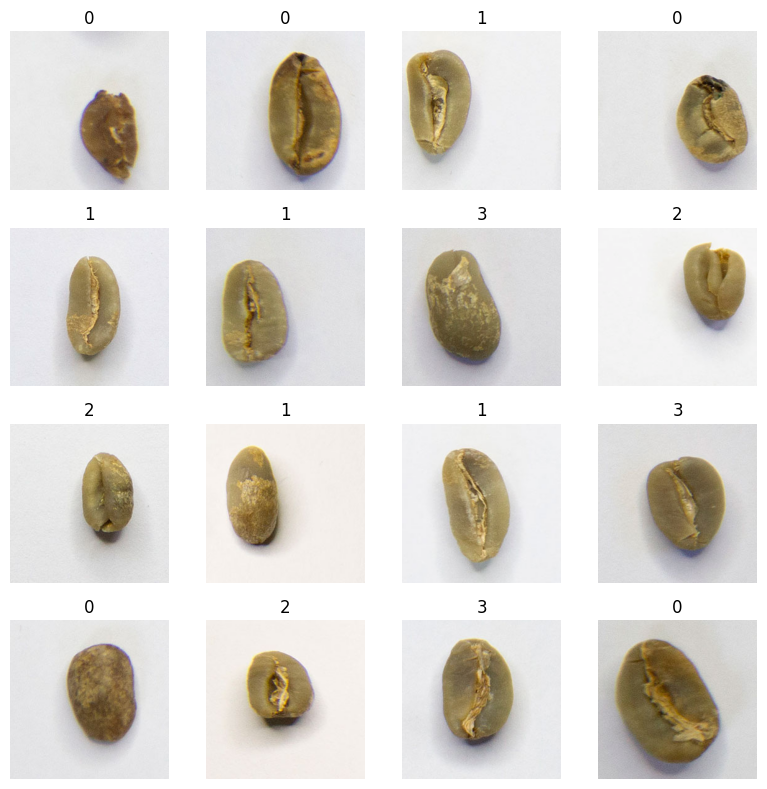

In [30]:
# =========================================
# [P5.3.1] SANITY BATCH VISUALIZATION
# =========================================

import matplotlib.pyplot as plt
import numpy as np

dl_train, dl_val, dl_test = build_dataloaders(train_df, val_df, test_df, batch_size=16)

x, y = next(iter(dl_train))
print("Batch x:", x.shape, "Batch y:", y.shape)

# unnormalize for display
mean = torch.tensor(IMAGENET_MEAN).view(3,1,1)
std  = torch.tensor(IMAGENET_STD).view(3,1,1)
x_vis = (x * std + mean).clamp(0, 1)

# plot
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.ravel()
for i in range(16):
    img = x_vis[i].permute(1,2,0).cpu().numpy()
    axes[i].imshow(img)
    axes[i].set_title(int(y[i]))
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [31]:
# =========================================
# [P6.1.1] LOAD ARTIFACTS FOR QA
# =========================================

import pandas as pd
from pathlib import Path

DIR = Path("./artifacts_preprocess")

meta_raw = pd.read_csv(DIR / "meta_train_raw.csv")
meta_dg  = pd.read_csv(DIR / "meta_train_dedup_grouped.csv")
dropped  = pd.read_csv(DIR / "dropped_exact_duplicates.csv") if (DIR / "dropped_exact_duplicates.csv").exists() else None

print("meta_raw:", meta_raw.shape)
print("meta_dedup_grouped:", meta_dg.shape)
print("dropped_exact:", None if dropped is None else dropped.shape)

meta_raw: (1211, 5)
meta_dedup_grouped: (1200, 8)
dropped_exact: (11, 6)


In [32]:
# =========================================
# [P6.2.1] CHECK FILE EXISTENCE IN SPLITS
# =========================================

from pathlib import Path

train_df = pd.read_csv(DIR / "split_train.csv")
val_df   = pd.read_csv(DIR / "split_val.csv")
test_path = DIR / "split_test.csv"
test_df  = pd.read_csv(test_path) if test_path.exists() else None

def count_missing(df):
    return int((~df["filepath"].apply(lambda x: Path(x).exists())).sum())

miss_train = count_missing(train_df)
miss_val   = count_missing(val_df)
miss_test  = None if test_df is None else count_missing(test_df)

print("Missing files - train:", miss_train, "| val:", miss_val, "| test:", miss_test)
if miss_train or miss_val or (miss_test is not None and miss_test):
    raise FileNotFoundError("Ada filepath yang tidak ditemukan di split. Stop sebelum modeling.")

Missing files - train: 0 | val: 0 | test: 0


In [33]:
# =========================================
# [P6.2.2] GROUP LEAKAGE CHECK ACROSS SPLITS
# =========================================

def group_set(df):
    return set(df["group_id"].unique())

g_train = group_set(train_df)
g_val   = group_set(val_df)
g_test  = None if test_df is None else group_set(test_df)

leak_tv = len(g_train & g_val)
print("Leak groups train<->val:", leak_tv)

if leak_tv > 0:
    raise ValueError("Group leakage detected between train and val. Stop.")

if g_test is not None:
    leak_tt = len(g_train & g_test)
    leak_vt = len(g_val & g_test)
    print("Leak groups train<->test:", leak_tt)
    print("Leak groups val<->test:", leak_vt)
    if leak_tt > 0 or leak_vt > 0:
        raise ValueError("Group leakage detected with test split. Stop.")

print("PASS ✅ No group leakage across splits.")

Leak groups train<->val: 0
Leak groups train<->test: 0
Leak groups val<->test: 0
PASS ✅ No group leakage across splits.


In [34]:
# =========================================
# [P6.2.3] CLASS DISTRIBUTION PER SPLIT
# =========================================

def dist_table(df, name):
    vc = df["class_name"].value_counts().sort_index()
    out = vc.rename(name).to_frame()
    out["pct"] = (out[name] / len(df) * 100).round(2)
    return out

dist_train = dist_table(train_df, "train_count")
dist_val   = dist_table(val_df, "val_count")
dist_test  = None if test_df is None else dist_table(test_df, "test_count")

print(dist_train)
print("\n", dist_val)
if dist_test is not None:
    print("\n", dist_test)

            train_count    pct
class_name                    
defect              210  25.00
longberry           210  25.00
peaberry            211  25.12
premium             209  24.88

             val_count    pct
class_name                  
defect             46  24.60
longberry          47  25.13
peaberry           45  24.06
premium            49  26.20

             test_count    pct
class_name                   
defect              44  25.43
longberry           43  24.86
peaberry            44  25.43
premium             42  24.28


In [35]:
# =========================================
# [P6.3.1] SAVE preprocessing_report.json/.md
# =========================================

import json

report = {
    "counts": {
        "meta_raw_rows": int(len(meta_raw)),
        "meta_dedup_grouped_rows": int(len(meta_dg)),
        "dropped_exact_rows": None if dropped is None else int(len(dropped)),
        "split_train_rows": int(len(train_df)),
        "split_val_rows": int(len(val_df)),
        "split_test_rows": None if test_df is None else int(len(test_df)),
    },
    "groups": {
        "total_groups": int(meta_dg["group_id"].nunique()),
        "train_groups": int(train_df["group_id"].nunique()),
        "val_groups": int(val_df["group_id"].nunique()),
        "test_groups": None if test_df is None else int(test_df["group_id"].nunique()),
        "group_leak_train_val": int(len(set(train_df["group_id"]) & set(val_df["group_id"]))),
        "group_leak_train_test": None if test_df is None else int(len(set(train_df["group_id"]) & set(test_df["group_id"]))),
        "group_leak_val_test": None if test_df is None else int(len(set(val_df["group_id"]) & set(test_df["group_id"]))),
    },
    "class_distribution": {
        "train": train_df["class_name"].value_counts().to_dict(),
        "val": val_df["class_name"].value_counts().to_dict(),
        "test": None if test_df is None else test_df["class_name"].value_counts().to_dict(),
    },
    "seed": SEED if "SEED" in globals() else None,
    "notes": [
        "Block P4 augmentation intentionally deferred to Notebook 4 (treatment) pending Notebook 3 diagnosis.",
        "Splits are group-aware to mitigate leakage-like effects from near-duplicates.",
    ],
}

# Save JSON
json_path = DIR / "preprocessing_report.json"
with open(json_path, "w") as f:
    json.dump(report, f, indent=2)

# Save Markdown
md_lines = []
md_lines.append("# Preprocessing QA Report (Notebook 2)\n")
md_lines.append("## Counts\n")
for k, v in report["counts"].items():
    md_lines.append(f"- **{k}**: {v}\n")
md_lines.append("\n## Group Integrity\n")
for k, v in report["groups"].items():
    md_lines.append(f"- **{k}**: {v}\n")
md_lines.append("\n## Class Distribution\n")
md_lines.append("### Train\n")
md_lines.append(str(train_df["class_name"].value_counts()) + "\n")
md_lines.append("\n### Val\n")
md_lines.append(str(val_df["class_name"].value_counts()) + "\n")
if test_df is not None:
    md_lines.append("\n### Test\n")
    md_lines.append(str(test_df["class_name"].value_counts()) + "\n")

md_path = DIR / "preprocessing_report.md"
md_path.write_text("".join(md_lines), encoding="utf-8")

print("Saved:", json_path)
print("Saved:", md_path)

Saved: artifacts_preprocess/preprocessing_report.json
Saved: artifacts_preprocess/preprocessing_report.md
